---

## Primeiro Trabalho de Aprendizado Profundo

---
Com base no código fornecido abaixo, baseado parcialmente nos notebooks do livro https://udlbook.github.io/udlbook/, efetue as tarefas delineadas abaixo:



1.  Implemente os métodos ReLU e sigmoid e suas respectivas derivadas indicator_function e d_sigmoid na classe FNN (1.0 ponto
2.  Complete a implementação do método backpropagation na classe FNN (2.0 pontos)
3.  Com base no método optimize, na class FNN, que calcula o gradiente descendente estocático, implemente os métodos de otimização momentum e adam (2.0 pontos).
4.  Execute os testes em cada um dos datasets para verificar a corretude de sua implementação. Testes os métodos momentum e adam e modifique os parâmetros de treinamento para obter os melhores resultados e faça uma análise. (1.0 pontos)
5. Refaça os experimentos usando a função de ativação sigmoid (0.5 ponto) e analise os resultados obtidos (0.5 ponto)
6. Modifique o método minibatch para que armazene o histórico da perda ao longo de cada época. Plote o gráfico da evolução da perda ao longo do treinamento para cada teste (1.0 ponto)
7. Modifique o método train_minibatch para que armazene os pesos e biases que gerarm o melhor resultado de treinamento (1.0 ponto)
8. Crie uma função que meça o erro médio da predição para os dados de teste (1.0 ponto)





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

A classe Scaler é usada para normalizar os dados. Em geral, para problemas de regressão, faz-se a normalização apenas da entrada X.

In [2]:
class Scaler():

  def __init__(self,data):
    self.mean = np.mean(data)
    self.std = np.std(data)

  def transform(self,data, target_mean = 0.0, target_std = 1.0):
    normalized_data = (data - self.mean) / self.std

    # Scale to desired std and shift to desired mean
    normalized_data = normalized_data * target_std + target_mean
    return normalized_data

  def invert_transform(self,data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    normalized_data = normalized_data * self.std + self.mean
    return normalized_data

A classe DataSet é usada para representar dados na forma (X,y) onde X contém os dados de entrada e y contém os respectivos rótulos. O campo shape_X é usado para descrever a estrutura original dos dados de entrada. Por exemplo, se X é um reticulado bidimensional m x n, então shape_X = (m,n). O campo shape_X é usado para reestruturar o array X para fins de visualização de certos tipos de dados.

In [3]:
class DataSet:
  """
    Class used to encode the input features X and labels y for
    the experiments using the feed forward neural network

    Attributes:
      id (int): dataset id
      X (np.array): input features
      y (np.array): labels
      dim_X (int): dimension of X
      dim_y (int): dimension of y
      type (str): "grid" if the input x is originally defined on a grid
      shape_X (shape): dimensions of the input features encoded as a shape
    Class Attributes:
      num_data_sets (int): used to create the ids

  """

  num_data_sets = 0

  def __init__(self,X,y,type = "array",id = None, name="None",shape_X = None):
    """
    Args:
        X (np.array): Input features
        y (np.array): Labels
        id (int): dataset id
        name (str): dataset name
        shape_X (tuple): dimensions of the input features encoded as numpy shape tuple
    """

    self.id = 0
    self.X = X
    self.y = y
    self.dim_X = len(X.shape)
    self.dim_y = len(y.shape)
    self.type = type
    self.shape_X = shape_X


    if (id == None):
      self.id = DataSet.num_data_sets
    else:
      self.id = id

    if (name == None):
      self.name = "dataset"+str(self.id)
    else:
      self.name = name

    DataSet.num_data_sets += 1

  def info(self):
    """
    prints the information about the dataset
    """
    print(f"Data set = {self.name}")
    print(f"X = {self.X}")
    print(f"y = {self.y}")
    print(f"Dim(X) = {self.dim_X}")
    print(f"Dim(y) = {self.dim_y}")


A classe DataFactory contém exemplos de datasets de treinamento e teste para os experimentos.

In [4]:
class DataFactory:
  """
    Class used to create dataset examples for the experiments

    Attributes:

    Class Attributes:

  """

  @staticmethod
  def gaussian_func():
    """
      A Gaussian function
    """

    X_train = np.arange(-5,5.1,0.1)
    error = np.random.normal(0,0.1,X_train.size)
    y_train = np.exp(-X_train**2)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    y_test = np.exp(-X_train**2)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset, test_dataset

  @staticmethod
  def bimodal_func():
    """
      A bimodal function
    """

    X_train = np.arange(-5,5.1,0.1)
    error = np.random.normal(0,0.1,X_train.size)
    y_train = np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    y_test = np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset, test_dataset

  @staticmethod
  def gabor_func():
    """
      A Gabor function
    """

    X_train = np.arange(-10,10.1,0.05)
    error = np.random.normal(0,0.1,X_train.size)
    y_train = np.exp(-X_train**2/16)*4*np.sin(4*X_train)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    y_test = np.exp(-X_train**2/16)*4*np.sin(4*X_train)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset,test_dataset

  @staticmethod
  def sinusoidal_func():
    """
      A Gabor function
    """

    X_train = np.arange(-10,10.1,0.05)
    error = np.random.normal(0,0.1,X_train.size)
    #y = np.exp(-x**2/16)*1*np.sin(4*x)+error
    y_train = np.sin(2*X_train)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.1,X_train.size)
    #y = np.exp(-x**2/16)*1*np.sin(4*x)+error
    y_test = np.sin(2*X_train)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset,test_dataset

  @staticmethod
  def wave_func():
    """
      A wave function
    """

    X_train = np.arange(-10,10.1,0.1)
    error = np.random.normal(0,0.5,X_train.size)
    y_train = np.exp(-(X_train+4)**2/32)*1*np.sin(4*X_train)+np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    train_dataset = DataSet(X_train,y_train)

    error = np.random.normal(0,0.5,X_train.size)
    y_test = np.exp(-(X_train+4)**2/32)*1*np.sin(4*X_train)+np.exp(-(X_train+2)**2)+ 4*np.exp(-(X_train-2)**2)+error
    test_dataset = DataSet(X_train,y_test)

    return train_dataset,test_dataset

  @staticmethod
  def circle():
    """
      A circle with noise
    """

    theta = np.arange(-np.pi,np.pi+0.01,np.pi/32)
    error1 = np.random.normal(0,0.03,theta.size)
    error2 = np.random.normal(0,0.03,theta.size)
    x = np.cos(theta)+error1
    y = np.sin(theta)+error2
    train_dataset = DataSet(theta,np.hstack([x.reshape(-1,1),y.reshape(-1,1)]))

    error1 = np.random.normal(0,0.03,theta.size)
    error2 = np.random.normal(0,0.03,theta.size)
    x = np.cos(theta)+error1
    y = np.sin(theta)+error2
    test_dataset = DataSet(theta,np.hstack([x.reshape(-1,1),y.reshape(-1,1)]))

    return train_dataset,test_dataset

  @staticmethod
  def sinusoidal_surface():
    """
      A piece of a sinusoidal surface
    """

    xi = np.arange(-5,5.01,0.5)
    yi = np.arange(-5,5.01,0.5)
    error = np.random.normal(0,0.1,xi.size)
    x_grid,y_grid = np.meshgrid(xi,yi)
    r = np.sqrt(x_grid**2 + y_grid**2)
    z = np.sin(r)+error

    xf = x_grid.flatten()
    yf = y_grid.flatten()
    zf = z.flatten()
    x = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1)])
    y = zf

    train_dataset = DataSet(x,y,"grid",shape_X = (xi.size,yi.size))

    dx =  np.random.normal(0,0.1,xi.size)
    dy =  np.random.normal(0,0.1,yi.size)
    xi = np.arange(-5,5.01,0.5) + dx
    yi = np.arange(-5,5.01,0.5) + dy
    error = np.random.normal(0,0.1,xi.size)
    x_grid,y_grid = np.meshgrid(xi,yi)
    r = np.sqrt(x_grid**2 + y_grid**2)
    z = np.sin(r)+error

    xf = x_grid.flatten()
    yf = y_grid.flatten()
    zf = z.flatten()
    x = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1)])
    y = zf

    test_dataset = DataSet(x,y,"grid",shape_X = (xi.size,yi.size))

    return train_dataset, test_dataset

  @staticmethod
  def sphere():
    """
      A sphere
    """

    theta = np.arange(0,2*np.pi+0.01,0.25)
    phi = np.arange(0,np.pi+0.01,0.25)
    theta_grid, phi_grid = np.meshgrid(theta,phi)
    error1 = 0.0 #np.random.normal(0,0.05,theta.size)
    error2 = 0.0 #np.random.normal(0,0.05,theta.size)
    error3 = 0.0 #np.random.normal(0,0.05,theta.size)

    X = np.sin(phi_grid) * np.cos(theta_grid) + error1
    Y = np.sin(phi_grid) * np.sin(theta_grid) + error2
    Z = np.cos(phi_grid) + error3

    tf = theta_grid.flatten()
    pf= phi_grid.flatten()
    xf = X.flatten()
    yf = Y.flatten()
    zf = Z.flatten()

    x = np.hstack([tf.reshape(-1,1),pf.reshape(-1,1)])
    y = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1),zf.reshape(-1,1)])

    train_dataset = DataSet(x,y,"grid",shape_X = (theta.size,phi.size))

    d_theta = np.random.normal(0,0.05,theta.size)
    d_phi = np.random.normal(0,0.05,phi.size)
    theta = np.arange(0,2*np.pi+0.01,0.25) + d_theta
    phi = np.arange(0,np.pi+0.01,0.25) + d_phi
    theta_grid, phi_grid = np.meshgrid(theta,phi)
    error1 = 0.0 #np.random.normal(0,0.05,theta.size)
    error2 = 0.0 #np.random.normal(0,0.05,theta.size)
    error3 = 0.0 #np.random.normal(0,0.05,theta.size)

    X = np.sin(phi_grid) * np.cos(theta_grid) + error1
    Y = np.sin(phi_grid) * np.sin(theta_grid) + error2
    Z = np.cos(phi_grid) + error3

    tf = theta_grid.flatten()
    pf= phi_grid.flatten()
    xf = X.flatten()
    yf = Y.flatten()
    zf = Z.flatten()

    x = np.hstack([tf.reshape(-1,1),pf.reshape(-1,1)])
    y = np.hstack([xf.reshape(-1,1),yf.reshape(-1,1),zf.reshape(-1,1)])

    test_dataset = DataSet(x,y,"grid",shape_X = (theta.size,phi.size))


    return train_dataset, test_dataset

  #Generated by DeepSeek
  @staticmethod
  def create_minibatches_advanced(X, y, batch_size, shuffle=True, drop_last=True):
    """
    Creates minibatches with option to drop last incomplete batch.

    Args:
        X: Input features
        y: Labels
        batch_size: Size of each minibatch
        shuffle: Whether to shuffle data
        drop_last: Whether to drop last incomplete batch

    Yields:
        (X_batch, y_batch) tuples
    """
    assert len(X) == len(y), "X and y must have the same length"

    n_samples = len(X)

    if shuffle:
        indices = np.random.permutation(n_samples)
        X = X[indices]
        y = y[indices]

    n_batches = n_samples // batch_size
    if not drop_last and n_samples % batch_size != 0:
        n_batches += 1

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X[start:end]
        y_batch = y[start:end]
        yield X_batch, y_batch





A classe DataDisplay é usada para visualizar os dados e as predições

In [5]:
class DataDisplay:
  """
      Class with methods used to display the datasets
  """

  @staticmethod
  def display_func_1D(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                            y_lim_inf = -10, y_lim_sup = 10, title = "Display"):
    """
    Displays datasets describing a 1D function

    Args:
        data (list): list of datasets to be displayed
        dataPred (DataSet): Prediction (x,y_pred)
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        title (str): title as a string

    Yields: None
    """
    fix, ax = plt.subplots()
    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)
      if (dataset.dim_X != 1) and (dataset.dim_y != 1):
          print("Data is not a 1D function")
          return
      ax.plot(dataset.X , dataset.y,color = c,marker = ".")

    ax.set_xlim([x_lim_inf,x_lim_sup]);ax.set_ylim([y_lim_inf, y_lim_sup])
    ax.set_xlabel('X'); ax.set_ylabel('y')
    if title is not None:
      ax.set_title(title)
    plt.show()

  @staticmethod
  def display_param_curv_2D(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                                  y_lim_inf = -10, y_lim_sup = 10, title = "Display"):
    """
    Displays a datasets describing a 1D parametric function

    Args:
        dataset_list (list): list of datasets to be displayed
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        title (str): title as a string

    Yields: None

    """
    fix, ax = plt.subplots()

    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)
      if (dataset.dim_X != 1) and (dataset.dim_y != 2):
        print("Data is not a parametric curve")
        return

      yf = dataset.y.transpose().flatten().reshape(2,-1)

      x = yf[0]
      y = yf[1]

      ax.plot(x , y,color = c, marker = ".")


    ax.set_xlim([x_lim_inf,x_lim_sup]);ax.set_ylim([y_lim_inf, y_lim_sup])
    ax.set_xlabel('x'); ax.set_ylabel('y')
    if title is not None:
      ax.set_title(title)
    plt.show()

  @staticmethod
  def display_heightmap(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                              y_lim_inf = -10, y_lim_sup = 10,
                              z_lim_inf = 0, z_lim_sup = 10,
                              title = "Display"):
    """
    Displays datasets describing height maps
    Adapted from https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

    Args:
        dataset_list (list): list of datasets to be displayed
        dataPred (DataSet): Prediction (x,y_pred)
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        z_lim_inf (float): minimum z limit of the window
        z_lim_sup (float): maximum z limit of the window

        title (str): title as a string

    Yields: None

    """

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)
      if (dataset.dim_X != 2) and (dataset.dim_y != 1):
          print("Data is not a heightmap")
          return

      ax.set_xlim(x_lim_inf, x_lim_sup)
      ax.set_ylim(y_lim_inf, y_lim_sup)
      ax.set_zlim(z_lim_inf, z_lim_sup)

      xdata = dataset.X.transpose().flatten().reshape(2,-1)
      X = xdata[0].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Y = xdata[1].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Z = dataset.y.reshape(dataset.shape_X[0],dataset.shape_X[1])

      # Plot the surface.
      scatter = ax.scatter(X, Y, Z, color = c , marker = ".")

    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    plt.show()

  @staticmethod
  def display_param_surface(dataset_list, x_lim_inf = -10 , x_lim_sup = 10,
                              y_lim_inf = -10, y_lim_sup = 10,
                              z_lim_inf = 0, z_lim_sup = 10,
                              title = "Display"):

    """
    Displays datasets describing parametric surfaces
    Adapted from https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

    Args:
        dataset_list: list of datasets to be displayed
        dataPred (DataSet): Prediction (x,y_pred)
        x_lim_inf (float): minimum x limit of the window
        x_lim_sup (float): maximum x limit of the window
        y_lim_inf (float): minimum y limit of the window
        y_lim_sup (float): maximum y limit of the window
        z_lim_inf (float): minimum z limit of the window
        z_lim_sup (float): maximum z limit of the window

        title (str): title as a string

    Yields: None

    """

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.set_xlim(x_lim_inf, x_lim_sup)
    ax.set_ylim(y_lim_inf, y_lim_sup)
    ax.set_zlim(z_lim_inf, z_lim_sup)

    for i,dataset in enumerate(dataset_list):
      c = "C"+str(i)

      if (dataset.dim_X != 2) and (dataset.dim_y != 3):
        print("Data is not a parametric surface")
        return

      ydata = dataset.y.transpose().flatten().reshape(3,-1)
      X = ydata[0].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Y = ydata[1].reshape(dataset.shape_X[0],dataset.shape_X[1])
      Z = ydata[2].reshape(dataset.shape_X[0],dataset.shape_X[1])

      # Plot the surface.
      scatter = ax.scatter(X, Y, Z, color = c)


    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    plt.show()


Classe que contém a implementação da rede neural FeedForward.

In [6]:
class FFN:

  """
    Class used to encode the input features x and labels y for
    the experiments using the feed forward neural network

    Attributes:
      K (int): number of layers
      D_i: dimension of the input
      D_h: list containing the dimensions of the hidden layers (starting index is zero)
      D_o: dimension of the output

      all_weights (list): list containing (K+1) weight matrices
      all_biases (list): list containing (K+1) bias matrices
      all_f (list): list containg the (K+1) pre-activations. The first one is the input
      all_h (list): list containg the (K+1) hidden neurons (pos-activation)
      all_dl_dweights (list): list containing (K+1) derivatives of the loss function over the weight matrices
      all_dl_dbiases (list): list containing (K+1) derivatives of the loss function over the biases
      all_dl_df (list): list containg the (K+1) derivatives of the loss function over the pre-activations (f)
      all_dl_dh (list): list containg the (K+1) derivatives of the loss function over the activations (h)
      all_dl_dweights (list): list containing (K+1) accumlated derivatives dl/d_omega used for the minibatch training
      all_dl_dbiases (list): list containing (K+1) accumlated derivatives dl/d_beta used for the minibatch training


    Class Attributes:
      bar (str): Text bar used in information display

  """


  bar = "-----------------------------------------------------------------------------------------------"

  def __init__(self,K,D_i,D_h,D_o, activation = "ReLU"):
    self.K = K
    self.D_i = D_i
    self.D_o = D_o
    self.D_h = D_h
    self.all_weights = [None]*(K+1)
    self.all_biases = [None]*(K+1)
    # We'll store the pre-activations at each layer in a list "all_f"
    # and the activations in a second list "all_h".
    self.all_f = [None] * (K+1)
    self.all_h = [None] * (K+1)


    # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
    self.all_dl_dweights = [None] * (K+1)
    self.all_dl_dbiases = [None] * (K+1)
    # And we'll store the derivatives of the loss with respect to the activation and preactivations in lists
    self.all_dl_df = [None] * (K+1)
    self.all_dl_dh = [None] * (K+1)

    #Armazena as derivadas dos pesos e bias de todas as instancias do conjunto de treinamento (ou batch)
    self.all_dL_dweights = [None]*(K+1)
    self.all_dL_dbiases = [None]*(K+1)

    #self.learning_rate = learning_rate
    #self.activation = self.ReLU
    #self.d_activation = self.indicator_function

    if (activation =="ReLU"):
      print("Using ReLU")
      self.activation = self.ReLU
      self.d_activation = self.indicator_function
    elif (activation == "Sigmoid"):
      print("Using Sigmoid")
      self.activation = self.sigmoid
      self.d_activation = self.d_sigmoid

    # Set seed so we always get the same random numbers
    #np.random.seed(0)

  def ReLU(self,preactivation):
    """
    Defines the Rectified Linear Unit (ReLU) function
    """
    #Substituir o código abaixo por sua solução
    result = np.zeros_like(preactivation)
    return result

  def indicator_function(self,x):
    """
    Derivative dh/df when h = ReLU(x)
    """
    #Substituir o código abaixo por sua solução
    result = np.array(x)
    return result


  def sigmoid(self,preactivation):
    """
    Defines the logistic function
    """
    #substituir o código abaixo por sua solução
    result = np.array(preactivation)
    return result

  def d_sigmoid(self,preactivation):
    """
    Defines the derivative of the logistic function
    """
    #substituir o código abaixo por sua solução
    result = np.array(preactivation)
    return result


  def initialize(self,config):
    """
    Initializes the weights
    """
    self.config = config

    if self.config.initialization=="He":
      self.initialize_He()
    elif self.config.initialization=="D_max":
      self.initialize_D_max()
    else:
      print("Error: Unknown initilization")

  def initialize_D_max(self):
    """
    D_max initialization
    """
    #np.random.seed(0)
    mean = 0
    d_max = max(self.D_h)
    std = np.sqrt(2/d_max)
    # Create input and output layers

    # Cria um array  D x D_i de valores aleatorios obtidos de uma dist. com os pesos que multiplicam a entrada x
    self.all_weights[0] = np.random.normal(mean,std,size=(self.D_h[0], self.D_i))
    # Cria um array  D_o x D de valores aleatorios obtidos de uma dist. com os pesos que multiplicam as ativações da última camada
    self.all_weights[-1] = np.random.normal(mean,std,size=(self.D_o, self.D_h[-1]))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada 1
    self.all_biases[0] = np.random.normal(mean,std,size =(self.D_h[0],1))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada de saida (K)
    self.all_biases[-1]= np.random.normal(mean,std,size =(self.D_o,1))

    # Create intermediate layers
    # Para cada camada intermediaria criar as matrizes de pesos 6x6 e bias 6x1

    for layer in range(1,self.K):
      self.all_weights[layer] = np.random.normal(mean,std,size=(self.D_h[layer],self.D_h[layer-1]))
      self.all_biases[layer] = np.random.normal(mean,std,size=(self.D_h[layer],1))

    for layer in range(self.K+1):
      self.all_dL_dweights[layer] = np.zeros_like(self.all_weights[layer])
      self.all_dL_dbiases[layer] =  np.zeros_like(self.all_biases[layer])

  def initialize_He(self):
    """
    He initialization
    """
    #np.random.seed(0)
    mean = 0

    # Create input and output layers

    # Cria um array  D x D_i de valores aleatorios obtidos de uma dist. com os pesos que multiplicam a entrada x
    self.all_weights[0] = np.random.normal(mean,np.sqrt(2/self.D_i),size=(self.D_h[0], self.D_i))
    # Cria um array  D_o x D de valores aleatorios obtidos de uma dist. com os pesos que multiplicam as ativações da última camada
    self.all_weights[-1] = np.random.normal(mean,np.sqrt(2/self.D_h[-1]),size=(self.D_o, self.D_h[-1]))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada 1
    self.all_biases[0] = np.random.normal(mean,np.sqrt(2/self.D_i),size =(self.D_h[0],1))
    # Cria um array  6 x 1 de valores aleatorios obtidos de uma dist. com os bias da camada de saida (K)
    self.all_biases[-1]= np.random.normal(mean,np.sqrt(2/self.D_h[-1]),size =(self.D_o,1))

    # Create intermediate layers
    # Para cada camada intermediaria criar as matrizes de pesos 6x6 e bias 6x1
    for layer in range(1,self.K):
      self.all_weights[layer] = np.random.normal(mean,np.sqrt(2/self.D_h[layer-1]),size=(self.D_h[layer],self.D_h[layer-1]))
      self.all_biases[layer] = np.random.normal(mean,np.sqrt(2/self.D_h[layer-1]),size=(self.D_h[layer],1))

    for layer in range(self.K+1):
      self.all_dL_dweights[layer] = np.zeros_like(self.all_weights[layer])
      self.all_dL_dbiases[layer] =  np.zeros_like(self.all_biases[layer])

  def zero_grad(self):
    """
    Clear the gradients. Set them to zero
    """
    for layer in range(self.K+1):
      self.all_dL_dweights[layer] = np.zeros_like(self.all_weights[layer])
      self.all_dL_dbiases[layer] =  np.zeros_like(self.all_biases[layer])


  def least_squares_loss(self, pred, y):
    """
    Least squares loss
    """
    x = pred-y
    #return np.sum((pred-y) * (pred-y))
    return np.square(x).sum()

  def d_loss_d_output(self, pred, y):
    """
    Derivative of the least squares
    """
    return 2*(pred-y)

  def reduce_learning_rate(self,epoch):
    if epoch!=0 and epoch%1000 == 0:
      self.config.learning_rate *=0.5
      self.config.learning_rate = max(self.config.learning_rate,0.00001)
      print("Learning rate = ",self.config.learning_rate)

  def forward(self, xi, all_weights, all_biases):
    """
    Forward pass
    Args:
        xi (np.array): input instance (take care of the correct shape (D_i,1) when using)
        all_weights (list): list containing all weight matrices for all layers
        all_biases (list): list containing all biases arrays for all layers

    Yields:
        pred (np.array): output (shape (D_o,1))
        all_f: list containing all pre-activations
        all_h: list containing all pos-activations

    """

    K = self.K

    #For convenience, we'll set
    # all_h[0] to be the input, and all_f[K] will be the output
    self.all_h[0] = xi

    # Run through the layers, calculating all_f[0...K-1] and all_h[1...K]
    for layer in range(K):
        # Update preactivations and activations at this layer according to eqn 7.17
        # Remember to use np.matmul for matrix multiplications
        # TODO -- Replace the lines below
        #all_f[layer] = all_h[layer]
        #all_h[layer+1] = all_f[layer]
        self.all_f[layer] = all_biases[layer]+np.matmul(all_weights[layer],self.all_h[layer])
        self.all_h[layer+1] = self.activation(self.all_f[layer])
        #print(layer,self.all_f[layer].shape,self.all_h[layer].shape)
    # Compute the output from the last hidden layer
    # TODO -- Replace the line below
    #all_f[K] = np.zeros_like(all_biases[-1])
    self.all_f[K] = all_biases[K]+np.matmul(all_weights[K],self.all_h[K])

    # Retrieve the output
    predi = self.all_f[K]

    return predi, self.all_f, self.all_h


  # Main backward pass routine
  def backward_pass(self,yi):
    """
    Forward pass
    Args:
        yi (np.array): output (take care of the correct shape (D_o,1) when using)

    Yields:
        all_dl_weights: updated derivatives of the loss over the weights
        all_dl_biases: updated derivatives of the biases over the weights

    """

    K = self.K

    # Compute derivatives of the loss with respect to the network output
    self.all_dl_df[K] = np.array(self.d_loss_d_output(self.all_f[K],yi))

    # Now work backwards through the network
    for layer in range(K,-1,-1):
      # TODO Calculate the derivatives of the loss with respect to the biases at layer from all_dl_df[layer]. (eq 7.22)
      # NOTE!  To take a copy of matrix X, use Z=np.array(X)
      # REPLACE THIS LINE

      #Substitua a linha de código abaixo por sua resposta
      self.all_dl_dbiases[layer] = np.zeros_like(self.all_biases[layer])


      # TODO Calculate the derivatives of the loss with respect to the weights at layer from all_dl_df[layer] and all_h[layer] (eq 7.23)
      # Don't forget to use np.matmul
      # REPLACE THIS LINE

      #Substitua a linha de código abaixo por sua resposta
      self.all_dl_dweights[layer] = np.zeros_like(self.all_weights[layer])


      # TODO: calculate the derivatives of the loss with respect to the activations from weight and derivatives of next preactivations (second part of last line of eq 7.25)
      # REPLACE THIS LINE

      #Substitua a linha de código abaixo por sua resposta
      self.all_dl_dh[layer] = np.zeros_like(self.all_h[layer])

      if layer > 0:
        # TODO Calculate the derivatives of the loss with respect to the pre-activation f (use derivative of ReLu function, first part of last line of eq. 7.25)
        # REPLACE THIS LINE

        #Substitua a linha de código abaixo por sua resposta
        self.all_dl_df[layer-1] = np.zeros_like(self.all_f[layer-1])


    for layer in range(K+1):
      self.all_dL_dweights[layer] += self.all_dl_dweights[layer]
      self.all_dL_dbiases[layer] += self.all_dl_dbiases[layer]


    return self.all_dl_dweights, self.all_dl_dbiases

  def predict(self,xi):
    """
    Given an input xi predicts the output predi using the learned model
    Args:
        xi (np.array): input (take care of the correct shape (D_i,1) when using)

    Yields:
        predi (np.array): output (take care of the correct shape (D_o,1) when using)

    """
    xi = np.array(xi).reshape(self.D_i,1)
    predi, *_ = self.forward(xi, self.all_weights, self.all_biases)
    return predi


  def predictAll(self,X):
    """
    Given an input x predicts all labels y
    Args:
        x (np.array): input

    Yields:
        y (np.array): output

    """
    y = np.zeros((X.shape[0],self.D_o))

    for i in range(X.shape[0]):
      y[i] = self.predict(X[i]).flatten()

    return y

  def momentum(self):
    #Implemente o código do método momentum (ver Equação 6.11)
    return self.optimize(self)

  def adam(self):
    #Implemente o código do método adam (ver Equação 6.11)
    return self.optimize(self)

  def optimize(self):
    """
    Computes the gradient descent or stochastic gradient descent
    """
    for layer in range(self.K+1):
      self.all_weights[layer] -= self.config.learning_rate*self.all_dL_dweights[layer]/self.config.batch_size
      self.all_biases[layer] -= self.config.learning_rate*self.all_dL_dbiases[layer]/self.config.batch_size

  def train_full(self, display_freq = 100):
    """
    Train using full data
    Args:
      display_freq (int) : frequency of information display
    """

    self.initialize(self.config)
    self.config.batch_size = self.config.X.shape[0] # for full batch we average all instances
    X = self.config.X
    y = self.config.y
    K = self.K
    num_epochs = self.config.num_epochs

    for epoch in range(num_epochs+1):

      self.display_info(epoch, FFN.bar + "\nEpoch: "+str(epoch));

      total_loss = 0
      self.zero_grad()

      for xi,yi in zip(X,y):
        xi = np.array(xi).reshape(self.D_i,1)
        yi = np.array(yi).reshape(self.D_o,1)
        yi_pred, *_ = self.forward(xi, self.all_weights, self.all_biases)
        loss = self.least_squares_loss(yi_pred, yi)
        total_loss += loss

        """
        if epoch%self.config.display_freq == 0:
          self.print_loss(xi, yi, pred, loss)
        """

        self.backward_pass(yi)
        #self.debug_backward_pass()

      self.display_info(epoch,"Total_loss = "+str(total_loss))
      self.display_info(epoch,"Mean Square Loss =" + str(total_loss/X.shape[0]))

      self.optimize()

      self.display_info(epoch, FFN.bar+"\n")


  def train_minibatches(self):
    """
    Train using minibatches
    """

    self.initialize(self.config)
    batch_size = self.config.batch_size
    X = self.config.X
    y = self.config.y
    K = self.K
    weight_decay_scheduling = self.config.weight_decay_scheduling
    num_epochs = self.config.num_epochs

    for epoch in range(num_epochs+1):

      if weight_decay_scheduling:
        self.reduce_learning_rate(epoch)

      self.display_info(epoch, FFN.bar + "\nEpoch: "+str(epoch));

      total_loss = 0
      batch_index = 0

      for batchX,batchY in DataFactory.create_minibatches_advanced(X,y,batch_size):


        self.zero_grad()
        batch_loss = 0

        for xi,yi in zip(batchX,batchY):
          xi = np.array(xi).reshape(self.D_i,1)
          yi = np.array(yi).reshape(self.D_o,1)
          yi_pred, *_ = self.forward(xi, self.all_weights, self.all_biases)
          loss = self.least_squares_loss(yi_pred, yi)
          batch_loss += loss
          self.backward_pass(yi)

        self.display_info(epoch,"Average batch %d loss = %f"%(batch_index,batch_loss/batch_size))

        self.optimize()

        batch_index += 1
        total_loss += batch_loss

      self.display_info(epoch,"Mean Square Loss =" + str(total_loss/X.shape[0]))
      self.display_info(epoch,FFN.bar)

  def display(self):
    """
    Display all the net information
    """
    print(FFN.bar)
    print("                                        Arquitetura da rede                                   ")
    print(FFN.bar)
    print("K=",self.K)
    print("D_i=",self.D_i)
    print("D_h=",self.D_h)
    print("D_o=",self.D_o)
    print("w_0=",self.all_weights[0].shape)
    print("b_0=",self.all_biases[0].shape)

    for layer in range(1,self.K+1):
      print("w_"+str(layer)+"=",self.all_weights[layer].shape)
      print("b_"+str(layer)+"=",self.all_biases[layer].shape)
    """
    print("w_0=",self.all_weights[0])
    print("b_0=",self.all_biases[0])
    for layer in range(1,self.K+1):
      print("w_"+str(layer)+"=",self.all_weights[layer])
      print("b_"+str(layer)+"=",self.all_biases[layer])
    """

    print(FFN.bar)
    print(FFN.bar)

  def display_info(self,epoch,msg):
    """
    Display training information
    """
    if epoch%self.config.display_freq == 0:
          print(msg)

  def print_loss(self,x,y,pred,loss):
    """
    Display the loss
    """
    #print("net_output = %3.3f y = %3.3f Loss = %3.3f"%(self.net_output, self.y, loss.item()))
    np.set_printoptions(formatter={'float': '{:.2f}'.format})
    print("x =",x.transpose(), end = " " )
    print("y =",y.transpose(), end = " ")
    print("pred =",pred.transpose(), end = " " )

    print("loss = %3.3f"%(loss.item()))


Classe utilizada para configurar o treinamento. Através dela são definidos os dados de entrada X, os rótulos y, a taxa de aprendizado, o número de épocas e o tamanho do batch. Também, através dela, é possível indicar se a taxa de aprendizado possui decaimento e o tipo de inicialização (He, ou dimensão máxima das camadas). A taxa de exibição e passada através do parâmetro display_freq.

In [7]:
class TrainingConfig:

  def __init__(self,X,y,learning_rate,num_epochs,batch_size = 1, weight_decay_scheduling = True, initialization = "He",display_freq = 500):

    """
    Configures the parameters for the training step

    Attributes:
      X (np.array): input data
      y (np.array): labels
      learning rate (float): learning rate
      num_epochs (float): number of epochs
      batch_size(int) : minbatch size used in SGD
      weight_decay|_schedulting (boolean) : decides if there is wait decay through epochs
      initialization (str): "He" -> He inicialization,
                            "D_max" - inicialization using 2/D_max,
                             where D_Max is the largest layer dimension
      display_freq (int): frequency of information display in multiples of epochs


    Class Attributes:
      bar (str): Text bar used in information display

  """
    self.X = X
    self.y = y
    self.learning_rate = learning_rate
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.weight_decay_scheduling = weight_decay_scheduling
    self.initialization = initialization
    self.display_freq = display_freq

  def display(self):
    """
    Display all the net information
    """
    print(FFN.bar)
    print("                          Configuração de Treinamento                             ")
    print(FFN.bar)

    print("learning rate=",self.learning_rate)
    print("num epochs=",self.num_epochs)
    print("batch size=",self.batch_size)
    print("decay_scheduling=",self.weight_decay_scheduling)
    print("initialization=",self.initialization)
    print("display_freq=",self.display_freq)

    print(FFN.bar)
    print(FFN.bar)



In [8]:
gaussian_dataset_train, gaussian_dataset_test = DataFactory.gaussian_func()
net_gauss = FFN(2,1,[5,3],1)
X_train = gaussian_dataset_train.X
y_train = gaussian_dataset_train.y
X_test = gaussian_dataset_test.X
y_test = gaussian_dataset_test.y
X_train_scaler = Scaler(X_train)
X_train_normalized = X_train_scaler.transform(X_train)
X_test_scaler = Scaler(X_test)
X_test_normalized = X_test_scaler.transform(X_test)

Using ReLU


In [9]:
config = TrainingConfig(X_train_normalized,y_train,0.05,2000,16,initialization="He",weight_decay_scheduling=False)
net_gauss.initialize(config)
net_gauss.display()
config.display()

-----------------------------------------------------------------------------------------------
                                        Arquitetura da rede                                   
-----------------------------------------------------------------------------------------------
K= 2
D_i= 1
D_h= [5, 3]
D_o= 1
w_0= (5, 1)
b_0= (5, 1)
w_1= (3, 5)
b_1= (3, 1)
w_2= (1, 3)
b_2= (1, 1)
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                          Configuração de Treinamento                             
-----------------------------------------------------------------------------------------------
learning rate= 0.05
num epochs= 2000
batch size= 16
decay_scheduling= False
initialization= He
display_freq= 500
------------------------------

In [10]:
net_gauss.train_minibatches()

-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 0.699153
Average batch 1 loss = 0.657551
Average batch 2 loss = 0.745458
Average batch 3 loss = 0.546098
Average batch 4 loss = 0.610850
Average batch 5 loss = 0.662271
Mean Square Loss =0.6212089364097534
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 500
Average batch 0 loss = 0.612358
Average batch 1 loss = 0.619404
Average batch 2 loss = 0.520720
Average batch 3 loss = 0.916625
Average batch 4 loss = 0.371511
Average batch 5 loss = 0.680300
Mean Square Loss =0.5894523433100441
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 1000
Average batch 0 loss = 0.59433

In [11]:
gaussian_pred_train = DataSet(X_train,net_gauss.predictAll(X_train_normalized))
gaussian_pred_test = DataSet(X_test,net_gauss.predictAll(X_test_normalized))

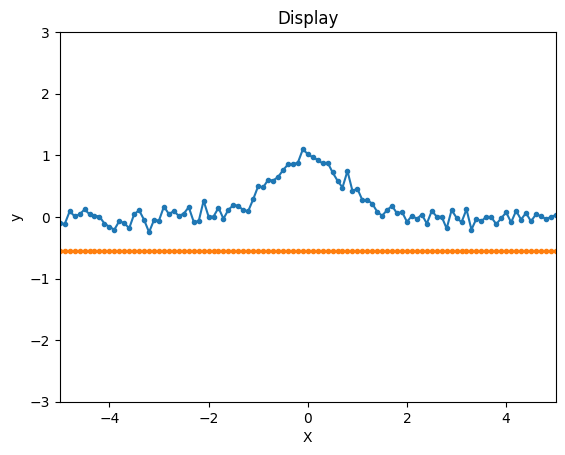

In [12]:
DataDisplay.display_func_1D([gaussian_dataset_test,gaussian_pred_test],x_lim_inf = -5,x_lim_sup =5, y_lim_inf = -3, y_lim_sup = 3)

In [13]:
bimodal_dataset_train , bimodal_dataset_test = DataFactory.bimodal_func()
net_bimodal = FFN(2,1,[5,5],1)
X_train = bimodal_dataset_train.X
y_train = bimodal_dataset_train.y
X_test = bimodal_dataset_test.X
y_test = bimodal_dataset_test.y
X_train_scaler = Scaler(X_train)
X_train_normalized = X_train_scaler.transform(X_train)
X_test_scaler = Scaler(X_test)
X_test_normalized = X_test_scaler.transform(X_test)

Using ReLU


In [14]:
config = TrainingConfig(X_train_normalized,y_train,0.01,2000,16,initialization="He",weight_decay_scheduling=False)
net_bimodal.initialize(config)
net_bimodal.display()
config.display()

-----------------------------------------------------------------------------------------------
                                        Arquitetura da rede                                   
-----------------------------------------------------------------------------------------------
K= 2
D_i= 1
D_h= [5, 5]
D_o= 1
w_0= (5, 1)
b_0= (5, 1)
w_1= (5, 5)
b_1= (5, 1)
w_2= (1, 5)
b_2= (1, 1)
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                          Configuração de Treinamento                             
-----------------------------------------------------------------------------------------------
learning rate= 0.01
num epochs= 2000
batch size= 16
decay_scheduling= False
initialization= He
display_freq= 500
------------------------------

In [15]:
net_bimodal.train_minibatches()

-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 1.095416
Average batch 1 loss = 2.575012
Average batch 2 loss = 1.323612
Average batch 3 loss = 0.610181
Average batch 4 loss = 5.026285
Average batch 5 loss = 3.585419
Mean Square Loss =2.252027675088285
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 500
Average batch 0 loss = 3.160075
Average batch 1 loss = 3.858721
Average batch 2 loss = 1.911988
Average batch 3 loss = 2.887010
Average batch 4 loss = 1.139600
Average batch 5 loss = 1.391502
Mean Square Loss =2.2730926551063777
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 1000
Average batch 0 loss = 1.850828

In [16]:
bimodal_pred_train = DataSet(X_train,net_bimodal.predictAll(X_train_normalized))
bimodal_pred_test = DataSet(X_test,net_bimodal.predictAll(X_test_normalized))

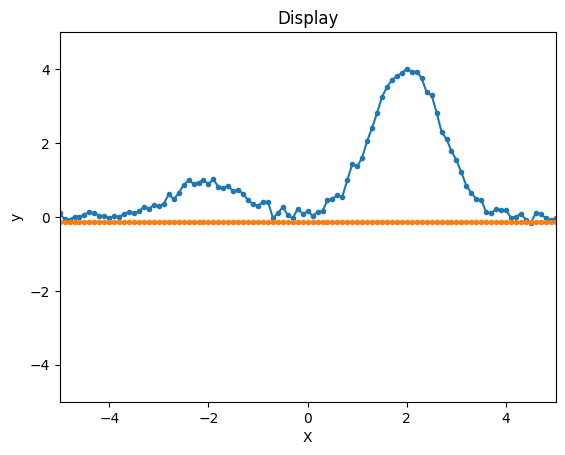

In [17]:
DataDisplay.display_func_1D([bimodal_dataset_test,bimodal_pred_test],x_lim_inf = -5,x_lim_sup =5, y_lim_inf = -5, y_lim_sup = 5)

In [18]:
gabor_dataset_train ,gabor_dataset_test = DataFactory.gabor_func()
net_gabor = FFN(4,1,[20,20,20,20],1)
X_train = gabor_dataset_train.X
y_train = gabor_dataset_train.y
X_test = gabor_dataset_test.X
y_test = gabor_dataset_test.y
X_train_scaler = Scaler(X_train)
X_train_normalized = X_train_scaler.transform(X_train)
X_test_scaler = Scaler(X_test)
X_test_normalized = X_test_scaler.transform(X_test)

Using ReLU


In [19]:
config = TrainingConfig(X_train_normalized,y_train,0.01,5000,32,initialization="He",weight_decay_scheduling=False)
net_gabor.initialize(config)
net_gabor.display()
config.display()

-----------------------------------------------------------------------------------------------
                                        Arquitetura da rede                                   
-----------------------------------------------------------------------------------------------
K= 4
D_i= 1
D_h= [20, 20, 20, 20]
D_o= 1
w_0= (20, 1)
b_0= (20, 1)
w_1= (20, 20)
b_1= (20, 1)
w_2= (20, 20)
b_2= (20, 1)
w_3= (20, 20)
b_3= (20, 1)
w_4= (1, 20)
b_4= (1, 1)
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                          Configuração de Treinamento                             
-----------------------------------------------------------------------------------------------
learning rate= 0.01
num epochs= 5000
batch size= 32
decay_scheduling= Fal

In [20]:
net_gabor.train_minibatches()

-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 2.906375
Average batch 1 loss = 1.178111
Average batch 2 loss = 2.025364
Average batch 3 loss = 1.365229
Average batch 4 loss = 2.586699
Average batch 5 loss = 2.550344
Average batch 6 loss = 2.605570
Average batch 7 loss = 1.781790
Average batch 8 loss = 1.541299
Average batch 9 loss = 2.102343
Average batch 10 loss = 1.692633
Average batch 11 loss = 1.808256
Mean Square Loss =1.9219114711589345
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 500
Average batch 0 loss = 1.160804
Average batch 1 loss = 2.338272
Average batch 2 loss = 2.124763
Average batch 3 loss = 2.838264
Average batch 4 loss = 2.886036
Average batch 5 loss = 2.058475
Average batch 6 loss = 1.457322
Average batch 7 loss = 1.021531
Average batch

In [21]:
gabor_pred_train = DataSet(X_train,net_gabor.predictAll(X_train_normalized))
gabor_pred_test = DataSet(X_test,net_gabor.predictAll(X_test_normalized))

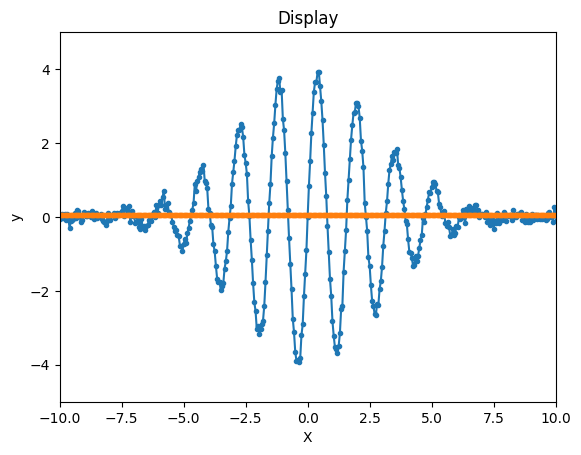

In [22]:
DataDisplay.display_func_1D([gabor_dataset_test,gabor_pred_test],x_lim_inf = -10,x_lim_sup =10, y_lim_inf = -5, y_lim_sup = 5)

In [23]:
circle_dataset_train, circle_dataset_test = DataFactory.circle()
net_circle = FFN(4,1,[20,20,20,20],2)
X_train = circle_dataset_train.X
y_train = circle_dataset_train.y
X_test = circle_dataset_test.X
y_test = circle_dataset_test.y
X_train_scaler = Scaler(X_train)
X_train_normalized = X_train_scaler.transform(X_train)
X_test_scaler = Scaler(X_test)
X_test_normalized = X_test_scaler.transform(X_test)

Using ReLU


In [24]:
config = TrainingConfig(X_train_normalized,y_train,0.01,2000,16,initialization="He",weight_decay_scheduling=False)
net_circle.initialize(config)
net_circle.display()
config.display()

-----------------------------------------------------------------------------------------------
                                        Arquitetura da rede                                   
-----------------------------------------------------------------------------------------------
K= 4
D_i= 1
D_h= [20, 20, 20, 20]
D_o= 2
w_0= (20, 1)
b_0= (20, 1)
w_1= (20, 20)
b_1= (20, 1)
w_2= (20, 20)
b_2= (20, 1)
w_3= (20, 20)
b_3= (20, 1)
w_4= (2, 20)
b_4= (2, 1)
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                          Configuração de Treinamento                             
-----------------------------------------------------------------------------------------------
learning rate= 0.01
num epochs= 2000
batch size= 16
decay_scheduling= Fal

In [25]:
net_circle.train_minibatches()

-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 1.235690
Average batch 1 loss = 1.273962
Average batch 2 loss = 0.961874
Average batch 3 loss = 1.171961
Mean Square Loss =1.1430118644436535
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
Epoch: 500
Average batch 0 loss = 1.428255
Average batch 1 loss = 1.046660
Average batch 2 loss = 1.147612
Average batch 3 loss = 1.067286
Mean Square Loss =1.154415499311561
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 1000
Average batch 0 loss = 1.008235
Average batch 1 loss = 1.137267
Average batch 2 loss = 1.345016
Average batch 3 loss = 1.150454
Mean Square Loss =1.1423931169841008
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Epoch: 1500
Average batch 0 loss = 0.912063
Average batch 1 loss = 1.285009
Average batch 2 loss = 1.277963
Average batch 3 loss = 1.223031
Mean Square Loss =1.15644718

In [26]:
circle_pred_train = DataSet(X_train,net_circle.predictAll(X_train_normalized))
circle_pred_test = DataSet(X_test,net_circle.predictAll(X_test_normalized))

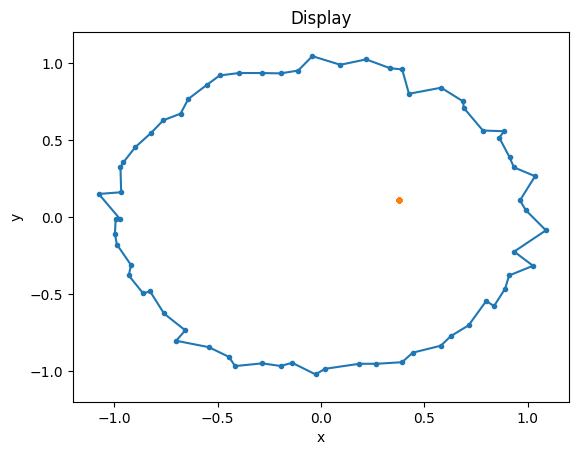

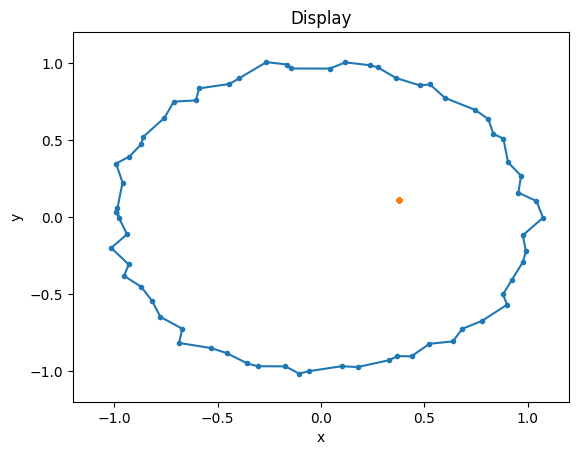

In [27]:
DataDisplay.display_param_curv_2D([circle_dataset_train,circle_pred_test],x_lim_inf = -1.2,x_lim_sup =1.2, y_lim_inf = -1.2, y_lim_sup = 1.2)
DataDisplay.display_param_curv_2D([circle_dataset_test,circle_pred_test],x_lim_inf = -1.2,x_lim_sup =1.2, y_lim_inf = -1.2, y_lim_sup = 1.2)

In [28]:
sinusoidal_surface_dataset_train, sinusoidal_surface_dataset_test = DataFactory.sinusoidal_surface()
net_sin_surf = FFN(4,2,[20,20,20,20],1)
X_train = sinusoidal_surface_dataset_train.X
y_train = sinusoidal_surface_dataset_train.y
X_test = sinusoidal_surface_dataset_test.X
y_test = sinusoidal_surface_dataset_test.y
X_train_scaler = Scaler(X_train)
X_train_normalized = X_train_scaler.transform(X_train)
X_test_scaler = Scaler(X_test)
X_test_normalized = X_test_scaler.transform(X_test)


Using ReLU


In [29]:
config = TrainingConfig(X_train_normalized,y_train,0.01,2000,16,initialization="He",weight_decay_scheduling=False)
net_sin_surf.initialize(config)
net_sin_surf.display()
config.display()

-----------------------------------------------------------------------------------------------
                                        Arquitetura da rede                                   
-----------------------------------------------------------------------------------------------
K= 4
D_i= 2
D_h= [20, 20, 20, 20]
D_o= 1
w_0= (20, 2)
b_0= (20, 1)
w_1= (20, 20)
b_1= (20, 1)
w_2= (20, 20)
b_2= (20, 1)
w_3= (20, 20)
b_3= (20, 1)
w_4= (1, 20)
b_4= (1, 1)
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                          Configuração de Treinamento                             
-----------------------------------------------------------------------------------------------
learning rate= 0.01
num epochs= 2000
batch size= 16
decay_scheduling= Fal

In [30]:
net_sin_surf.train_minibatches()

-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 0.503048
Average batch 1 loss = 0.409143
Average batch 2 loss = 0.484666
Average batch 3 loss = 0.478829
Average batch 4 loss = 0.555822
Average batch 5 loss = 0.700362
Average batch 6 loss = 0.249450
Average batch 7 loss = 0.357039
Average batch 8 loss = 0.371253
Average batch 9 loss = 0.510636
Average batch 10 loss = 0.528436
Average batch 11 loss = 0.608261
Average batch 12 loss = 0.516772
Average batch 13 loss = 0.444214
Average batch 14 loss = 0.336323
Average batch 15 loss = 0.578922
Average batch 16 loss = 0.382990
Average batch 17 loss = 0.388177
Average batch 18 loss = 0.441395
Average batch 19 loss = 0.572537
Average batch 20 loss = 0.513675
Average batch 21 loss = 0.444785
Average batch 22 loss = 0.440962
Average batch 23 loss = 0.476608
Average batch 24 loss = 0.390568
Average batch 25 loss = 0.530162
Average batch 26 loss = 0.504569
Mean Square Lo

In [31]:
sinusoidal_surface_pred_train = DataSet(X_train,net_sin_surf.predictAll(X_train_normalized),shape_X=sinusoidal_surface_dataset_train.shape_X)
sinusoidal_surface_pred_test = DataSet(X_test,net_sin_surf.predictAll(X_test_normalized),shape_X=sinusoidal_surface_dataset_train.shape_X)

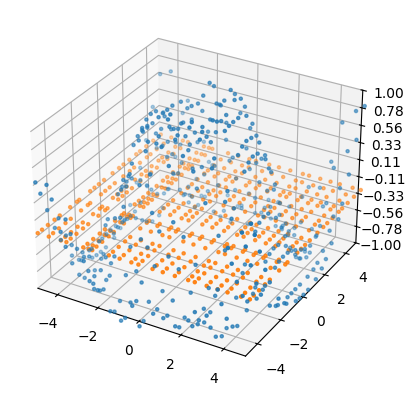

In [32]:
DataDisplay.display_heightmap([sinusoidal_surface_dataset_test, sinusoidal_surface_pred_test],x_lim_inf = -5,x_lim_sup =5, y_lim_inf = -5, y_lim_sup = 5,z_lim_inf = -1, z_lim_sup = 1)

In [33]:
sphere_dataset_train, sphere_dataset_test = DataFactory.sphere()
net_sphere = FFN(4,2,[20,20,20,20],3)
X_train = sphere_dataset_train.X
y_train = sphere_dataset_train.y
X_test = sphere_dataset_test.X
y_test = sphere_dataset_test.y
X_train_scaler = Scaler(X_train)
X_train_normalized = X_train_scaler.transform(X_train)
X_test_scaler = Scaler(X_test)
X_test_normalized = X_test_scaler.transform(X_test)

Using ReLU


In [34]:
config = TrainingConfig(X_train_normalized,y_train,0.01,2000,16,initialization="He",weight_decay_scheduling=False)
net_sphere.initialize(config)
net_sphere.display()
config.display()

-----------------------------------------------------------------------------------------------
                                        Arquitetura da rede                                   
-----------------------------------------------------------------------------------------------
K= 4
D_i= 2
D_h= [20, 20, 20, 20]
D_o= 3
w_0= (20, 2)
b_0= (20, 1)
w_1= (20, 20)
b_1= (20, 1)
w_2= (20, 20)
b_2= (20, 1)
w_3= (20, 20)
b_3= (20, 1)
w_4= (3, 20)
b_4= (3, 1)
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
                          Configuração de Treinamento                             
-----------------------------------------------------------------------------------------------
learning rate= 0.01
num epochs= 2000
batch size= 16
decay_scheduling= Fal

In [35]:
net_sphere.train_minibatches()

-----------------------------------------------------------------------------------------------
Epoch: 0
Average batch 0 loss = 1.132503
Average batch 1 loss = 1.745231
Average batch 2 loss = 1.138623
Average batch 3 loss = 1.071441
Average batch 4 loss = 1.448015
Average batch 5 loss = 1.041791
Average batch 6 loss = 1.324039
Average batch 7 loss = 1.338820
Average batch 8 loss = 1.190957
Average batch 9 loss = 1.100348
Average batch 10 loss = 1.380105
Average batch 11 loss = 1.178757
Average batch 12 loss = 1.280401
Average batch 13 loss = 1.192181
Average batch 14 loss = 1.182525
Average batch 15 loss = 1.082396
Average batch 16 loss = 1.151973
Average batch 17 loss = 1.208609
Average batch 18 loss = 1.229005
Average batch 19 loss = 1.476900
Average batch 20 loss = 1.505134
Mean Square Loss =1.2496924777258298
-----------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------

In [36]:
sphere_pred_train = DataSet(X_train,net_sphere.predictAll(X_train_normalized),shape_X=sphere_dataset_train.shape_X)
sphere_pred_test = DataSet(X_test,net_sphere.predictAll(X_test_normalized),shape_X=sphere_dataset_train.shape_X)

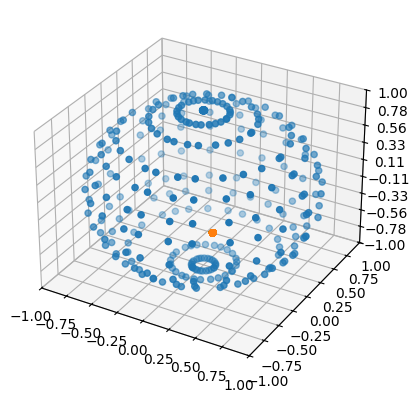

In [37]:
DataDisplay.display_param_surface([sphere_dataset_test, sphere_pred_test],x_lim_inf = -1,x_lim_sup =1, y_lim_inf = -1, y_lim_sup = 1,z_lim_inf = -1, z_lim_sup = 1)